In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
from GPErks.gp.experiment import GPExperiment
from GPErks.train.emulator import GPEmulator
from GPErks.perks.inference import Inference
from GPErks.train.early_stop import NoEarlyStoppingCriterion
from GPErks.train.early_stop import (
    GLEarlyStoppingCriterion,
    PQEarlyStoppingCriterion,
    UPEarlyStoppingCriterion,
)
from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
from GPErks.log.logger import get_logger
from GPErks.utils.random import set_seed
log = get_logger()
seed = 8
set_seed(seed)

# Model 1: Basic GP

In [2]:
x_labels=pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\input\xlabels_EP.txt',delim_whitespace=True,header=None)
inputOrig = pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\input\X_EP.txt',index_col=None,delim_whitespace=True,header=None)
inputOrig.columns=x_labels
print(inputOrig)

     (CV_ventricles,)  (k_ventricles,)  (k_FEC,)  (CV_atria,)  (k_atria,)  \
0            0.399840         0.323390   2.38256     0.792266    0.418700   
1            0.411078         0.484808   2.97470     0.436497    0.392057   
2            0.480070         0.255120   5.45824     0.707493    0.233964   
3            0.723138         0.219679   7.08363     1.011880    0.440564   
4            0.613551         0.212641   6.01868     0.914252    0.278204   
..                ...              ...       ...          ...         ...   
175          0.787312         0.392919   4.22219     0.385685    0.226360   
176          0.436460         0.348932   3.06019     0.699568    0.471580   
177          0.484816         0.466268   1.34156     0.437907    0.377097   
178          0.734602         0.210847   1.62463     0.444901    0.404824   
179          0.692167         0.415612   3.02559     0.847270    0.442109   

     (k_BB,)  
0    5.13714  
1    2.72577  
2    5.18898  
3    2.02218  


In [3]:
y_labels=pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\output\ylabels.txt',delim_whitespace=True,header=None)
outputOrig = pd.read_csv(r'C:\Users\pmzcwl\Documents\GitHub\Calibration\shared_simulations\output\Y.txt',index_col=None,delim_whitespace=True,header=None)
outputOrig.columns=y_labels
print(outputOrig)

     (A_TAT,)  (V_TAT,)
0     127.156  227.8230
1     251.071  188.8540
2     163.448  164.8120
3     110.207  110.6940
4     140.815  136.1450
..        ...       ...
175   321.082   94.4139
176   141.936  190.0140
177   236.662  224.8330
178   248.667  167.9450
179   118.693  115.3070

[180 rows x 2 columns]


In [4]:
# split original dataset in training, validation and testing sets
X=inputOrig
y=outputOrig

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=seed
)

Text(0, 0.5, 'V_TAT')

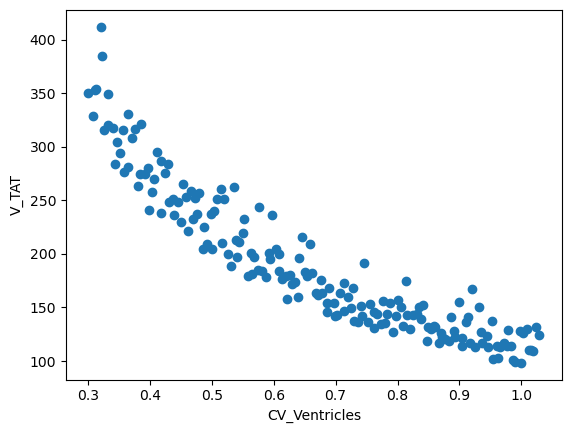

In [5]:
plt.plot(X.iloc[:,3],y.iloc[:,0],'o')
plt.xlabel('CV_Ventricles')
plt.ylabel('V_TAT')

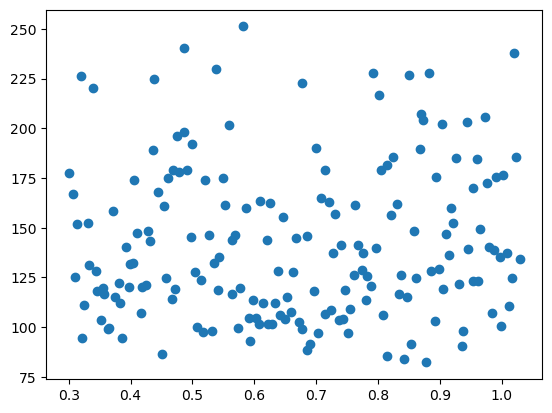

In [6]:
plt.plot(X.iloc[:,3],y.iloc[:,1],'o')

In [41]:
X

,"(CV_ventricles,)","(k_ventricles,)","(k_FEC,)","(CV_atria,)","(k_atria,)","(k_BB,)"
0,0.399840,0.323390,2.38256,0.792266,0.418700,5.13714
1,0.411078,0.484808,2.97470,0.436497,0.392057,2.72577
2,0.480070,0.255120,5.45824,0.707493,0.233964,5.18898
3,0.723138,0.219679,7.08363,1.011880,0.440564,2.02218
4,0.613551,0.212641,6.01868,0.914252,0.278204,1.60980
...,...,...,...,...,...,...
175,0.787312,0.392919,4.22219,0.385685,0.226360,2.26043
176,0.436460,0.348932,3.06019,0.699568,0.471580,4.25267
177,0.484816,0.466268,1.34156,0.437907,0.377097,5.09147
178,0.734602,0.210847,1.62463,0.444901,0.404824,2.36554


In [11]:
print(X.iloc[:,3],X.iloc[:,5],y.iloc[:,0])

0      0.792266
1      0.436497
2      0.707493
3      1.011880
4      0.914252
         ...   
175    0.385685
176    0.699568
177    0.437907
178    0.444901
179    0.847270
Name: (CV_atria,), Length: 180, dtype: float64 0      5.13714
1      2.72577
2      5.18898
3      2.02218
4      1.60980
        ...   
175    2.26043
176    4.25267
177    5.09147
178    2.36554
179    4.50165
Name: (k_BB,), Length: 180, dtype: float64 0      127.156
1      251.071
2      163.448
3      110.207
4      140.815
        ...   
175    321.082
176    141.936
177    236.662
178    248.667
179    118.693
Name: (A_TAT,), Length: 180, dtype: float64


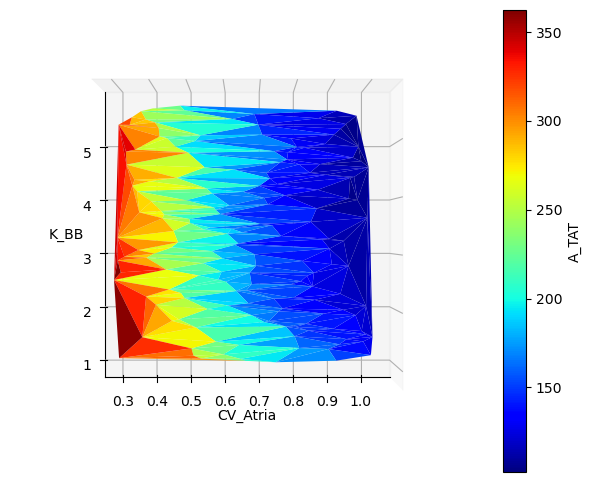

In [12]:
import sys
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy
from numpy.random import randn
from scipy import array, newaxis

# data = # your matrix here

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

surf=ax.plot_trisurf(X.iloc[:,3],X.iloc[:,5],y.iloc[:,0],cmap=cm.jet)
ax.zaxis.line.set_lw(0.)
ax.set_zticks([])
ax.set_xlabel('CV_Atria') 
ax.set_ylabel('K_BB') 
fig.colorbar(surf,label='A_TAT')
ax.view_init(-270, -90)

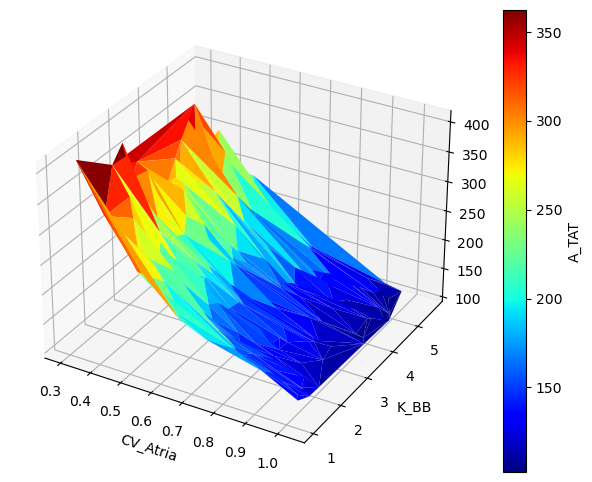

In [15]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

surf=ax.plot_trisurf(X.iloc[:,3],X.iloc[:,5],y.iloc[:,0],cmap=cm.jet)
ax.set_xlabel('CV_Atria') 
ax.set_ylabel('K_BB') 
fig.colorbar(surf,label='A_TAT')

In [70]:
np.min(y_train)

C:\Users\pmzcwl\AppData\Local\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


(A_TAT,)    98.9795
(V_TAT,)    82.2549
dtype: float64

In [71]:
from GPErks.gp.data.dataset import Dataset

In [72]:
y_labels.values.squeeze().tolist()

['A_TAT', 'V_TAT']

In [73]:
best_models=[]
best_train_stats=[]
emulators=[]
nMod = y_train.shape[1]
mse=[]
    
for i in range(nMod):

    
    dataset = Dataset(
        X_train.values,
        y_train.iloc[:,i].values,
        X_test=X_test.values,
        y_test=y_test.iloc[:,i].values,
        x_labels=x_labels.values.squeeze().tolist(),
        y_label=y_labels.values[i],
    
        )

    likelihood = GaussianLikelihood()
    mean_function = LinearMean(input_size=dataset.input_size)
    kernel = ScaleKernel(RBFKernel(ard_num_dims=dataset.input_size))
    metrics = [MeanSquaredError()]

    experiment = GPExperiment(
        dataset,
        likelihood,
        mean_function,
        kernel,
        n_restarts=5,
        metrics=metrics,
        seed=seed,  # reproducible training
        learn_noise=True
    )

    device = "cpu"
    optimizer = torch.optim.Adam(experiment.model.parameters(), lr=0.1)

    emulator = GPEmulator(experiment, device)
    best_model, best_train_stat = emulator.train(optimizer);
    mean,std=emulator.predict(X_test.values)
    mse.append(((mean-y_test.iloc[:,i].values)**2).mean())
    emulators.append(emulator)
    best_models.append(best_model)
    best_train_stats.append(best_train_stat)

INFO:2023-07-12 12:43:07,348:emulator:train:L84: Training emulator...
INFO:2023-07-12 12:43:07,354:emulator:train:L100: Running restart 1...


TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 6
-Input parameters: ['CV_ventricles', 'k_ventricles', 'k_FEC', 'CV_atria', 'k_atria', 'k_BB']
-Output size: 1
-Output feature: [array(['A_TAT'], dtype=object)]
-Sample size: 144
-Discrepancy: 0.0086
-Validation data available: No
-Testing data available: Yes (size = 36)


C:\Users\pmzcwl\AppData\Local\anaconda3\lib\site-packages\gpytorch\models\exact_gp.py:283: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
INFO:2023-07-12 12:43:08,096:emulator:_train_once:L316: [  1/100] Training Loss: 1.2825 - MeanSquaredError: 0.2926
INFO:2023-07-12 12:43:08,115:emulator:_train_once:L316: [  2/100] Training Loss: 1.2160 - MeanSquaredError: 0.2275
INFO:2023-07-12 12:43:08,135:emulator:_train_once:L316: [  3/100] Training Loss: 1.1592 - MeanSquaredError: 0.1765
INFO:2023-07-12 12:43:08,155:emulator:_train_once:L316: [  4/100] Training Loss: 1.1045 - MeanSquaredError: 0.1385
INFO:2023-07-12 12:43:08,192:emulator:_train_once:L316: [  5/100] Training Loss: 1.0515 - MeanSquaredError: 0.1110
INFO:2023-07-12 12:43:08,207:emulator:_train_once:L316: [  6/100] Training Loss: 1.0013 - MeanSquaredError: 0.0907
INFO:2023-07-12 12:43:08,222:emulator:_train_once:L316: [  7/100] Training Loss: 0.9541 - MeanSquaredErr

INFO:2023-07-12 12:43:09,440:emulator:_train_once:L316: [ 71/100] Training Loss: -1.4553 - MeanSquaredError: 0.0004
INFO:2023-07-12 12:43:09,460:emulator:_train_once:L316: [ 72/100] Training Loss: -1.4775 - MeanSquaredError: 0.0003
INFO:2023-07-12 12:43:09,481:emulator:_train_once:L316: [ 73/100] Training Loss: -1.4996 - MeanSquaredError: 0.0003
INFO:2023-07-12 12:43:09,502:emulator:_train_once:L316: [ 74/100] Training Loss: -1.5212 - MeanSquaredError: 0.0003
INFO:2023-07-12 12:43:09,522:emulator:_train_once:L316: [ 75/100] Training Loss: -1.5415 - MeanSquaredError: 0.0002
INFO:2023-07-12 12:43:09,537:emulator:_train_once:L316: [ 76/100] Training Loss: -1.5597 - MeanSquaredError: 0.0002
INFO:2023-07-12 12:43:09,555:emulator:_train_once:L316: [ 77/100] Training Loss: -1.5760 - MeanSquaredError: 0.0002
INFO:2023-07-12 12:43:09,571:emulator:_train_once:L316: [ 78/100] Training Loss: -1.5917 - MeanSquaredError: 0.0002
INFO:2023-07-12 12:43:09,586:emulator:_train_once:L316: [ 79/100] Traini

INFO:2023-07-12 12:43:10,750:emulator:_train_once:L316: [ 41/100] Training Loss: -0.9473 - MeanSquaredError: 0.0015
INFO:2023-07-12 12:43:10,767:emulator:_train_once:L316: [ 42/100] Training Loss: -0.9868 - MeanSquaredError: 0.0013
INFO:2023-07-12 12:43:10,781:emulator:_train_once:L316: [ 43/100] Training Loss: -1.0256 - MeanSquaredError: 0.0011
INFO:2023-07-12 12:43:10,799:emulator:_train_once:L316: [ 44/100] Training Loss: -1.0634 - MeanSquaredError: 0.0010
INFO:2023-07-12 12:43:10,819:emulator:_train_once:L316: [ 45/100] Training Loss: -1.1002 - MeanSquaredError: 0.0008
INFO:2023-07-12 12:43:10,837:emulator:_train_once:L316: [ 46/100] Training Loss: -1.1359 - MeanSquaredError: 0.0007
INFO:2023-07-12 12:43:10,855:emulator:_train_once:L316: [ 47/100] Training Loss: -1.1698 - MeanSquaredError: 0.0006
INFO:2023-07-12 12:43:10,872:emulator:_train_once:L316: [ 48/100] Training Loss: -1.2013 - MeanSquaredError: 0.0006
INFO:2023-07-12 12:43:10,888:emulator:_train_once:L316: [ 49/100] Traini

INFO:2023-07-12 12:43:12,460:emulator:_train_once:L316: [ 11/100] Training Loss: 1.0278 - MeanSquaredError: 0.0437
INFO:2023-07-12 12:43:12,481:emulator:_train_once:L316: [ 12/100] Training Loss: 0.9939 - MeanSquaredError: 0.0422
INFO:2023-07-12 12:43:12,500:emulator:_train_once:L316: [ 13/100] Training Loss: 0.9620 - MeanSquaredError: 0.0422
INFO:2023-07-12 12:43:12,520:emulator:_train_once:L316: [ 14/100] Training Loss: 0.9315 - MeanSquaredError: 0.0431
INFO:2023-07-12 12:43:12,542:emulator:_train_once:L316: [ 15/100] Training Loss: 0.9021 - MeanSquaredError: 0.0444
INFO:2023-07-12 12:43:12,562:emulator:_train_once:L316: [ 16/100] Training Loss: 0.8732 - MeanSquaredError: 0.0456
INFO:2023-07-12 12:43:12,581:emulator:_train_once:L316: [ 17/100] Training Loss: 0.8440 - MeanSquaredError: 0.0462
INFO:2023-07-12 12:43:12,599:emulator:_train_once:L316: [ 18/100] Training Loss: 0.8140 - MeanSquaredError: 0.0458
INFO:2023-07-12 12:43:12,621:emulator:_train_once:L316: [ 19/100] Training Loss:

INFO:2023-07-12 12:43:13,984:emulator:_train_once:L316: [ 82/100] Training Loss: -1.6643 - MeanSquaredError: 0.0002
INFO:2023-07-12 12:43:14,009:emulator:_train_once:L316: [ 83/100] Training Loss: -1.6777 - MeanSquaredError: 0.0002
INFO:2023-07-12 12:43:14,030:emulator:_train_once:L316: [ 84/100] Training Loss: -1.6903 - MeanSquaredError: 0.0001
INFO:2023-07-12 12:43:14,051:emulator:_train_once:L316: [ 85/100] Training Loss: -1.7024 - MeanSquaredError: 0.0001
INFO:2023-07-12 12:43:14,073:emulator:_train_once:L316: [ 86/100] Training Loss: -1.7142 - MeanSquaredError: 0.0001
INFO:2023-07-12 12:43:14,093:emulator:_train_once:L316: [ 87/100] Training Loss: -1.7256 - MeanSquaredError: 0.0001
INFO:2023-07-12 12:43:14,110:emulator:_train_once:L316: [ 88/100] Training Loss: -1.7361 - MeanSquaredError: 0.0001
INFO:2023-07-12 12:43:14,134:emulator:_train_once:L316: [ 89/100] Training Loss: -1.7459 - MeanSquaredError: 0.0001
INFO:2023-07-12 12:43:14,165:emulator:_train_once:L316: [ 90/100] Traini

INFO:2023-07-12 12:43:15,714:emulator:_train_once:L316: [ 52/100] Training Loss: -0.9095 - MeanSquaredError: 0.0017
INFO:2023-07-12 12:43:15,740:emulator:_train_once:L316: [ 53/100] Training Loss: -0.9526 - MeanSquaredError: 0.0014
INFO:2023-07-12 12:43:15,765:emulator:_train_once:L316: [ 54/100] Training Loss: -0.9952 - MeanSquaredError: 0.0012
INFO:2023-07-12 12:43:15,787:emulator:_train_once:L316: [ 55/100] Training Loss: -1.0370 - MeanSquaredError: 0.0010
INFO:2023-07-12 12:43:15,807:emulator:_train_once:L316: [ 56/100] Training Loss: -1.0765 - MeanSquaredError: 0.0009
INFO:2023-07-12 12:43:15,826:emulator:_train_once:L316: [ 57/100] Training Loss: -1.1130 - MeanSquaredError: 0.0007
INFO:2023-07-12 12:43:15,848:emulator:_train_once:L316: [ 58/100] Training Loss: -1.1470 - MeanSquaredError: 0.0006
INFO:2023-07-12 12:43:15,870:emulator:_train_once:L316: [ 59/100] Training Loss: -1.1797 - MeanSquaredError: 0.0006
INFO:2023-07-12 12:43:15,897:emulator:_train_once:L316: [ 60/100] Traini

INFO:2023-07-12 12:43:17,273:emulator:_train_once:L316: [ 22/100] Training Loss: -0.2141 - MeanSquaredError: 0.0042
INFO:2023-07-12 12:43:17,298:emulator:_train_once:L316: [ 23/100] Training Loss: -0.2652 - MeanSquaredError: 0.0042
INFO:2023-07-12 12:43:17,326:emulator:_train_once:L316: [ 24/100] Training Loss: -0.3168 - MeanSquaredError: 0.0042
INFO:2023-07-12 12:43:17,353:emulator:_train_once:L316: [ 25/100] Training Loss: -0.3680 - MeanSquaredError: 0.0043
INFO:2023-07-12 12:43:17,375:emulator:_train_once:L316: [ 26/100] Training Loss: -0.4179 - MeanSquaredError: 0.0043
INFO:2023-07-12 12:43:17,401:emulator:_train_once:L316: [ 27/100] Training Loss: -0.4662 - MeanSquaredError: 0.0043
INFO:2023-07-12 12:43:17,422:emulator:_train_once:L316: [ 28/100] Training Loss: -0.5125 - MeanSquaredError: 0.0043
INFO:2023-07-12 12:43:17,445:emulator:_train_once:L316: [ 29/100] Training Loss: -0.5569 - MeanSquaredError: 0.0042
INFO:2023-07-12 12:43:17,468:emulator:_train_once:L316: [ 30/100] Traini

INFO:2023-07-12 12:43:19,508:emulator:_train_once:L316: [ 93/100] Training Loss: -1.8819 - MeanSquaredError: 0.0001
INFO:2023-07-12 12:43:19,534:emulator:_train_once:L316: [ 94/100] Training Loss: -1.8853 - MeanSquaredError: 0.0001
INFO:2023-07-12 12:43:19,571:emulator:_train_once:L316: [ 95/100] Training Loss: -1.8888 - MeanSquaredError: 0.0001
INFO:2023-07-12 12:43:19,599:emulator:_train_once:L316: [ 96/100] Training Loss: -1.8917 - MeanSquaredError: 0.0001
INFO:2023-07-12 12:43:19,621:emulator:_train_once:L316: [ 97/100] Training Loss: -1.8942 - MeanSquaredError: 0.0001
INFO:2023-07-12 12:43:19,643:emulator:_train_once:L316: [ 98/100] Training Loss: -1.8966 - MeanSquaredError: 0.0001
INFO:2023-07-12 12:43:19,665:emulator:_train_once:L316: [ 99/100] Training Loss: -1.8992 - MeanSquaredError: 0.0001
INFO:2023-07-12 12:43:19,692:emulator:_train_once:L316: [100/100] Training Loss: -1.9017 - MeanSquaredError: 0.0001
INFO:2023-07-12 12:43:19,704:emulator:train:L113: Run restart 5.
INFO:20

TestExperiment dataset loaded.
Notes from the author:
"An example dataset to test GPErks' power!"
Dataset properties:
-Input size: 6
-Input parameters: ['CV_ventricles', 'k_ventricles', 'k_FEC', 'CV_atria', 'k_atria', 'k_BB']
-Output size: 1
-Output feature: [array(['V_TAT'], dtype=object)]
-Sample size: 144
-Discrepancy: 0.0086
-Validation data available: No
-Testing data available: Yes (size = 36)


INFO:2023-07-12 12:43:20,042:emulator:_train_once:L316: [  8/100] Training Loss: 1.1778 - MeanSquaredError: 0.1664
INFO:2023-07-12 12:43:20,066:emulator:_train_once:L316: [  9/100] Training Loss: 1.1276 - MeanSquaredError: 0.1463
INFO:2023-07-12 12:43:20,085:emulator:_train_once:L316: [ 10/100] Training Loss: 1.0804 - MeanSquaredError: 0.1295
INFO:2023-07-12 12:43:20,100:emulator:_train_once:L316: [ 11/100] Training Loss: 1.0347 - MeanSquaredError: 0.1153
INFO:2023-07-12 12:43:20,122:emulator:_train_once:L316: [ 12/100] Training Loss: 0.9898 - MeanSquaredError: 0.1035
INFO:2023-07-12 12:43:20,146:emulator:_train_once:L316: [ 13/100] Training Loss: 0.9455 - MeanSquaredError: 0.0939
INFO:2023-07-12 12:43:20,172:emulator:_train_once:L316: [ 14/100] Training Loss: 0.9016 - MeanSquaredError: 0.0862
INFO:2023-07-12 12:43:20,194:emulator:_train_once:L316: [ 15/100] Training Loss: 0.8583 - MeanSquaredError: 0.0800
INFO:2023-07-12 12:43:20,212:emulator:_train_once:L316: [ 16/100] Training Loss:

INFO:2023-07-12 12:43:21,457:emulator:_train_once:L316: [ 79/100] Training Loss: -1.0245 - MeanSquaredError: 0.0005
INFO:2023-07-12 12:43:21,476:emulator:_train_once:L316: [ 80/100] Training Loss: -1.0418 - MeanSquaredError: 0.0004
INFO:2023-07-12 12:43:21,493:emulator:_train_once:L316: [ 81/100] Training Loss: -1.0581 - MeanSquaredError: 0.0004
INFO:2023-07-12 12:43:21,509:emulator:_train_once:L316: [ 82/100] Training Loss: -1.0738 - MeanSquaredError: 0.0004
INFO:2023-07-12 12:43:21,527:emulator:_train_once:L316: [ 83/100] Training Loss: -1.0889 - MeanSquaredError: 0.0003
INFO:2023-07-12 12:43:21,542:emulator:_train_once:L316: [ 84/100] Training Loss: -1.1038 - MeanSquaredError: 0.0003
INFO:2023-07-12 12:43:21,561:emulator:_train_once:L316: [ 85/100] Training Loss: -1.1186 - MeanSquaredError: 0.0003
INFO:2023-07-12 12:43:21,582:emulator:_train_once:L316: [ 86/100] Training Loss: -1.1334 - MeanSquaredError: 0.0003
INFO:2023-07-12 12:43:21,601:emulator:_train_once:L316: [ 87/100] Traini

INFO:2023-07-12 12:43:22,735:emulator:_train_once:L316: [ 49/100] Training Loss: -0.8475 - MeanSquaredError: 0.0010
INFO:2023-07-12 12:43:22,757:emulator:_train_once:L316: [ 50/100] Training Loss: -0.8699 - MeanSquaredError: 0.0010
INFO:2023-07-12 12:43:22,776:emulator:_train_once:L316: [ 51/100] Training Loss: -0.8898 - MeanSquaredError: 0.0009
INFO:2023-07-12 12:43:22,793:emulator:_train_once:L316: [ 52/100] Training Loss: -0.9082 - MeanSquaredError: 0.0008
INFO:2023-07-12 12:43:22,809:emulator:_train_once:L316: [ 53/100] Training Loss: -0.9258 - MeanSquaredError: 0.0008
INFO:2023-07-12 12:43:22,825:emulator:_train_once:L316: [ 54/100] Training Loss: -0.9434 - MeanSquaredError: 0.0007
INFO:2023-07-12 12:43:22,846:emulator:_train_once:L316: [ 55/100] Training Loss: -0.9612 - MeanSquaredError: 0.0006
INFO:2023-07-12 12:43:22,864:emulator:_train_once:L316: [ 56/100] Training Loss: -0.9789 - MeanSquaredError: 0.0006
INFO:2023-07-12 12:43:22,882:emulator:_train_once:L316: [ 57/100] Traini

INFO:2023-07-12 12:43:24,043:emulator:_train_once:L316: [ 19/100] Training Loss: 0.8218 - MeanSquaredError: 0.0728
INFO:2023-07-12 12:43:24,066:emulator:_train_once:L316: [ 20/100] Training Loss: 0.7780 - MeanSquaredError: 0.0706
INFO:2023-07-12 12:43:24,084:emulator:_train_once:L316: [ 21/100] Training Loss: 0.7326 - MeanSquaredError: 0.0685
INFO:2023-07-12 12:43:24,102:emulator:_train_once:L316: [ 22/100] Training Loss: 0.6860 - MeanSquaredError: 0.0665
INFO:2023-07-12 12:43:24,120:emulator:_train_once:L316: [ 23/100] Training Loss: 0.6387 - MeanSquaredError: 0.0646
INFO:2023-07-12 12:43:24,139:emulator:_train_once:L316: [ 24/100] Training Loss: 0.5911 - MeanSquaredError: 0.0628
INFO:2023-07-12 12:43:24,172:emulator:_train_once:L316: [ 25/100] Training Loss: 0.5438 - MeanSquaredError: 0.0611
INFO:2023-07-12 12:43:24,222:emulator:_train_once:L316: [ 26/100] Training Loss: 0.4974 - MeanSquaredError: 0.0595
INFO:2023-07-12 12:43:24,258:emulator:_train_once:L316: [ 27/100] Training Loss:

INFO:2023-07-12 12:43:25,423:emulator:_train_once:L316: [ 90/100] Training Loss: -1.2876 - MeanSquaredError: 0.0001
INFO:2023-07-12 12:43:25,443:emulator:_train_once:L316: [ 91/100] Training Loss: -1.2996 - MeanSquaredError: 0.0001
INFO:2023-07-12 12:43:25,461:emulator:_train_once:L316: [ 92/100] Training Loss: -1.3107 - MeanSquaredError: 0.0001
INFO:2023-07-12 12:43:25,477:emulator:_train_once:L316: [ 93/100] Training Loss: -1.3211 - MeanSquaredError: 0.0001
INFO:2023-07-12 12:43:25,492:emulator:_train_once:L316: [ 94/100] Training Loss: -1.3319 - MeanSquaredError: 0.0001
INFO:2023-07-12 12:43:25,513:emulator:_train_once:L316: [ 95/100] Training Loss: -1.3428 - MeanSquaredError: 0.0001
INFO:2023-07-12 12:43:25,530:emulator:_train_once:L316: [ 96/100] Training Loss: -1.3541 - MeanSquaredError: 0.0001
INFO:2023-07-12 12:43:25,548:emulator:_train_once:L316: [ 97/100] Training Loss: -1.3651 - MeanSquaredError: 0.0001
INFO:2023-07-12 12:43:25,565:emulator:_train_once:L316: [ 98/100] Traini

INFO:2023-07-12 12:43:26,742:emulator:_train_once:L316: [ 60/100] Training Loss: -0.9439 - MeanSquaredError: 0.0008
INFO:2023-07-12 12:43:26,759:emulator:_train_once:L316: [ 61/100] Training Loss: -0.9601 - MeanSquaredError: 0.0007
INFO:2023-07-12 12:43:26,773:emulator:_train_once:L316: [ 62/100] Training Loss: -0.9770 - MeanSquaredError: 0.0007
INFO:2023-07-12 12:43:26,790:emulator:_train_once:L316: [ 63/100] Training Loss: -0.9953 - MeanSquaredError: 0.0006
INFO:2023-07-12 12:43:26,808:emulator:_train_once:L316: [ 64/100] Training Loss: -1.0145 - MeanSquaredError: 0.0005
INFO:2023-07-12 12:43:26,838:emulator:_train_once:L316: [ 65/100] Training Loss: -1.0340 - MeanSquaredError: 0.0005
INFO:2023-07-12 12:43:26,855:emulator:_train_once:L316: [ 66/100] Training Loss: -1.0529 - MeanSquaredError: 0.0004
INFO:2023-07-12 12:43:26,881:emulator:_train_once:L316: [ 67/100] Training Loss: -1.0712 - MeanSquaredError: 0.0004
INFO:2023-07-12 12:43:26,899:emulator:_train_once:L316: [ 68/100] Traini

INFO:2023-07-12 12:43:28,316:emulator:_train_once:L316: [ 30/100] Training Loss: -0.5667 - MeanSquaredError: 0.0030
INFO:2023-07-12 12:43:28,336:emulator:_train_once:L316: [ 31/100] Training Loss: -0.5959 - MeanSquaredError: 0.0027
INFO:2023-07-12 12:43:28,353:emulator:_train_once:L316: [ 32/100] Training Loss: -0.6236 - MeanSquaredError: 0.0025
INFO:2023-07-12 12:43:28,372:emulator:_train_once:L316: [ 33/100] Training Loss: -0.6508 - MeanSquaredError: 0.0023
INFO:2023-07-12 12:43:28,391:emulator:_train_once:L316: [ 34/100] Training Loss: -0.6783 - MeanSquaredError: 0.0021
INFO:2023-07-12 12:43:28,415:emulator:_train_once:L316: [ 35/100] Training Loss: -0.7063 - MeanSquaredError: 0.0019
INFO:2023-07-12 12:43:28,434:emulator:_train_once:L316: [ 36/100] Training Loss: -0.7350 - MeanSquaredError: 0.0017
INFO:2023-07-12 12:43:28,452:emulator:_train_once:L316: [ 37/100] Training Loss: -0.7643 - MeanSquaredError: 0.0016
INFO:2023-07-12 12:43:28,470:emulator:_train_once:L316: [ 38/100] Traini

INFO:2023-07-12 12:43:29,810:emulator:train:L113: Run restart 5.
INFO:2023-07-12 12:43:29,811:emulator:train:L116: Trained emulator.
INFO:2023-07-12 12:43:29,812:emulator:train:L150: Loading best model (restart: 5, epoch: 100)...
INFO:2023-07-12 12:43:29,822:emulator:train:L161: Loaded best model.
INFO:2023-07-12 12:43:29,825:emulator:train:L174: Loading best train stats (restart: 5, epoch: 100)...
INFO:2023-07-12 12:43:29,833:emulator:train:L199: Loaded best train stats.
INFO:2023-07-12 12:43:29,834:emulator:train:L201: The fitted emulator hyperparameters are:
INFO:2023-07-12 12:43:29,837:emulator:train:L202: 
Bias: 6.2433
Weights: tensor([    -3.9108,     -1.7924,     -3.3654,     -0.0081,      0.0178,
             0.0005])
Outputscale: 0.4238
Lengthscales: tensor([0.8154, 0.9607, 0.2142, 7.1397, 6.3166, 5.5489])
Likelihood noise: 0.0002


In [74]:
mse

[19.43251591267984, 5.423731421532157]

In [75]:
def normalise(data):
    dataMean = np.mean(data,axis=0)
    dataStd = np.std(data,axis=0)
    dataNorm = (data-dataMean)/(dataStd)
    return dataNorm,dataMean,dataStd

In [76]:
inputNorm,inputMean,inputStd = normalise(X_train)

In [77]:
outputNorm,outMean,outStd=normalise(y_train)

In [78]:
nDim = inputNorm.shape[1]

In [79]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=nDim))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [80]:
class ExactLRGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactLRGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.LinearMean(input_size=nDim)
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=nDim))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [81]:
class ZeroMeanGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ZeroMeanGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=nDim))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [82]:
def GPEnsemble(modelInput,modelOutput,meanFunc='constant'):
    models = []
    likelihoods = []
    MSE = []
    nMod = modelOutput.shape[1]
    X=torch.tensor(modelInput.values).float()
    
    for i in range(nMod):
        Y=torch.tensor(modelOutput.iloc[:,i].values).squeeze().float() 
        print(i)
        likelihoods.append(gpytorch.likelihoods.GaussianLikelihood())
        if meanFunc=='constant':
            models.append(ExactGPModel(X, Y, likelihoods[i]))
        if meanFunc=='linear':
            models.append(ExactLRGPModel(X, Y, likelihoods[i]))
        if meanFunc=='zero':
            models.append(ZeroMeanGPModel(X, Y, likelihoods[i]))
        smoke_test = ('CI' in os.environ)
        training_iter = 2 if smoke_test else 500


        # Find optimal model hyperparameters
        models[i].train()
        likelihoods[i].train()
        

        # Use the adam optimizer
        optimizer = torch.optim.Adam(models[i] .parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihoods[i], models[i] )


        for j in range(training_iter):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = models[i](X)
            # Calc loss and backprop gradients
            loss = -mll(output, Y)
            loss.backward()
            #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            #    j + 1, training_iter, loss.item(),
            #    models[i].covar_module.base_kernel.lengthscale.item(),
            #    models[i].likelihood.noise.item()
            #))
            optimizer.step()
    return models, likelihoods

In [83]:
def LRGPEnsemble(modelInput,modelOutput):
    
    nMod = modelOutput.shape[1]
    #outMean = np.mean(modelOutput,axis=0)
    #outStd = np.std(modelOutput,axis=0)
    #modelOutputNew = (modelOutput-outMean)/outStd.T
    #inMean = np.mean(modelInput,axis=0)
    #inStd = np.std(modelInput,axis=0)
    #modelInputNew = (modelInput-inMean)/inStd.T
    
    regression_model = LinearRegression()
    # Fit the data(train the model)
    regression_model.fit(modelInput, modelOutput)
    
    y_predicted = regression_model.predict(modelInput)
    
    modelOutputAdjusted = modelOutput - y_predicted
    
    modelsZM, likelihoodsZM = GPEnsemble(modelInput,modelOutputAdjusted,meanFunc='zero')
    
    return regression_model, modelsZM, likelihoodsZM

In [84]:
def GPEnsemblePredict(models,likelihoods,inputVals,outMean,outStd):
    #modelOutput = (modelOutputOrig-outMean)/outStd.T
    nMod = len(models)
    prediction=[]
    inputVals = inputVals.float()
    for i in range(nMod):
        models[i].eval()
        likelihoods[i].eval()
        out = outStd[i]*(likelihoods[i](models[i](inputVals)).mean)+outMean[i]
        prediction.append(out)
    return prediction

In [85]:
def LRGPEnsemblePredict(linearModel,models,likelihoods,inputVals,outMean,outStd):
    nMod = len(models)
    
    y_predictedSens = linearModel.predict(inputVals)
    inputVals = inputVals.float()
    prediction=[]
    for i in range(nMod):
        models[i].eval()
        likelihoods[i].eval()
        out = outStd[i]*(torch.tensor([y_predictedSens[:,i]])+likelihoods[i](models[i](inputVals)).mean)+outMean[i]
        prediction.append(out)
    return prediction



In [86]:
y_test

,"(A_TAT,)","(V_TAT,)"
138,152.5960,83.8327
36,276.6560,116.5560
169,161.5780,102.5980
143,178.9640,115.3980
126,251.1820,174.2230
133,197.4400,118.5170
102,130.3450,156.4190
32,153.9700,117.9430
120,209.0870,179.2280
145,145.6020,161.5950


In [87]:
144/4

36.0

In [111]:
output = np.zeros((36,7))
iters = 10
for i in range(36):
    
    output[i,0]=(i+1)*4
    
    for k in range(iters):
        
        idx = np.random.choice(len(X_train),(i+1)*4,replace=False)
        print(idx)
        X_train_reduced = X_train.iloc[idx,:]
        y_train_reduced = y_train.iloc[idx,:]

        inputNorm,inputMean,inputStd = normalise(X_train_reduced)
        outputNorm,outMean,outStd=normalise(y_train_reduced)

        models, likelihoods = GPEnsemble(inputNorm,outputNorm)
        modelsLR, likelihoodsLR = GPEnsemble(inputNorm,outputNorm,meanFunc="linear")
        regression_model, modelsZM, likelihoodsZM=LRGPEnsemble(inputNorm,outputNorm)

        for j in range(2):
            output[i,1+j] +=((GPEnsemblePredict(models,likelihoods,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[j]-torch.tensor(y_test.values)[:,j])**2).mean()/iters
            output[i,3+j] +=((GPEnsemblePredict(modelsLR,likelihoodsLR,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[j]-torch.tensor(y_test.values)[:,j])**2).mean()/iters
            output[i,5+j] +=((LRGPEnsemblePredict(regression_model,modelsZM,likelihoodsZM,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[j]-torch.tensor(y_test.values)[:,j])**2).mean()/iters
   

[136 125  28  99]
0
1
0
1
0
1
[ 10  71  47 120]
0
1
0
1
0
1
[ 76  67 116 109]
0
1
0
1
0
1
[ 93  97 141  37]
0
1
0
1
0
1
[ 14 141  53  26]
0
1
0
1
0
1
[ 51  19 108  48]
0
1
0
1
0
1
[103  54  24  89]
0
1
0
1
0
1
[ 23 134  45  37]
0
1
0
1
0
1
[ 60 107  73  21]
0
1
0
1
0
1
[48 10 46 15]
0
1
0
1
0
1
[142 136 141 110  18  91  86  51]
0
1
0
1
0
1
[  2 143  51  97  56 114  80  88]
0
1
0
1
0
1
[ 88 108  34  59  41 136  56  94]
0
1
0
1
0
1
[42 22 87 72 74 30 43 90]
0
1
0
1
0
1
[ 29   5  91  86 102   0 113   6]
0
1
0
1
0
1
[ 38 125  47 102  53  13  39  93]
0
1
0
1
0
1
[ 62  44  16 114  19  50 107 139]
0
1
0
1
0
1
[ 65  69  30 112  28 102  52 122]
0
1
0
1
0
1
[ 61  89 125   0  25 110  18   2]
0
1
0
1
0
1
[ 78 113  44  86  41  40  39  28]
0
1
0
1
0
1
[ 13  58 128 125  43 132  99 106  62   0  86 127]
0
1
0
1
0
1
[ 11   7 118   6 106 114  16  67  91  62  33  51]
0
1
0
1
0
1
[ 21 116  82  46 126 137  14 122 130  79  13  85]
0
1
0
1
0
1
[ 37  28 138 127  46 114  30  21  83  96  51  59]
0
1
0
1
0
1
[ 80

1
0
1
0
1
[ 11 133  45  72  24 126  95  52  68   2 107  33  17 116 135 120 138  62
  30  86 105  91  53 109  79 113  19  56  81  83  69  70  23  28  87 130]
0
1
0
1
0
1
[ 30  95  52  25  21  63  62  39 102  81  59  99  91  27 115   1  50  20
   7  71 143 137  14  87 119 129 121 138 128 141 105  19  49  37  79  34
 123  12  93  80]
0
1
0
1
0
1
[ 46  68  48  89  70  99  91 122  10  77  43 118  18  84 110   9 112 102
  93  24  55 133  95  96 109  26  17  63  45 106  29 131 139  32 127 107
  75  35   1  25]
0
1
0
1
0
1
[ 24  95  41  91  80 118  50  46  16  17 111  92  10 108  87  11  44 136
 112   1 129  81  39 140  66  96  18  20  35  32  57 130   2 102 115 121
 132   0 143 127]
0
1
0
1
0
1
[ 31  66 110  26   8  42   0 132 113  59  82 101  68  40 133  60  89  55
 104  32   7 130  98  83 114  93 103  75 102  49  90  80  85  84  71  10
 137 115  65  95]
0
1
0
1
0
1
[ 26  55 105  28 116 119  29  73  56  76  84 133 110 129  70  30 125 108
  77  62 106   8  74 136  87  57  25  51  99  40  67  

1
0
1
0
1
[ 88  16  73  92 124  67 103  38  76  40  30 113  94   9  85   3  42  64
  29  83  13  72  57  75  33  62  14  59  12   0  86 140   2  43  31  41
 122 137  61 142  90  50 111  87   6  99  24  18  19  15 112 116   4 108
 104 127]
0
1
0
1
0
1
[ 40  12 141   1  13  95   6  89 102  65   4 137 112  58  19  10 114  69
  50  20  94  16  86  35  66  47  98  75 109  31  61  62   0 143  29  71
  88 135  96  70  37  33  36 140 131  55  15  38  57 104  32 105  18 113
 117  34]
0
1
0
1
0
1
[ 66 133  57  47  26  75  55   9  15  37 121  82  84  85  43  14  22  12
  19  20  25  56 102   2  88 107  79  24  36  72  89  52  64 106  30 100
  45 116 137   7 132   4 118  10  41   8 128 135  65 110  31  70  68  23
  98 101]
0
1
0
1
0
1
[ 66  65   2 125  27 133  29  64  44  93  94  10 136  76  58 101 119 117
  61  77  87  85  26 110  74  95  57 139 116  75 106   3 127  70  56 102
  90 118 135  50  41 129  35  71 105 138 130  53  28  48  32  98  81  31
  15  13]
0
1
0
1
0
1
[ 27   2  55   9 111   0  

1
0
1
0
1
[ 79  12  98   9  60  93  90  91 136 124  70  11 142 103  89 102 112  69
  44   1 107  61 119 143 111  22  99  86 118 106  88   4  62  85 101   7
  38  97  10   0  96  57 127  41  29  78  17  76  25  42 110 105  83 120
  28  55 109  64  47  46  30  74 137 134  66 100  72  13]
0
1
0
1
0
1
[102  79  99  29  78  47  52 101  72  86 126  65  90 118 104  60  33  27
  56 117 107  44 112 111   2 103  16 132 136  57 115 110  51 137  50 139
  63   4  82  30  91  67  22 121 108 124  35  61 133 123  36  39  17  62
 130  70 109   8 138 119   7  31  92 100  97  66   3  84]
0
1
0
1
0
1
[109 132  31 104  51  95  68  84  67 101  79 131  80 115  92  16  61 137
  94 138  13  38  20 140  23  53  43 122  62  25  90 141  64  78  40  63
  66 142  83 126  88  18  44  82  29  11  47 105   0 119 124  19  12   9
  14  45   6  35  41  39  99  75 117   1  72   2 103 143]
0
1
0
1
0
1
[ 47 125  97  45 101  90  79   0  49  61 140 137 134  87 102  18 117  11
  38  98  56 130  68  64 113  85  62  63  76  24  

1
0
1
0
1
[ 68  41  79   6 115  77   8  96  18  90 111 120  53 100  59  94 129  26
 106  44 110  66 113 133 104  27  82 117  83  69 122 127  62  87  15  57
 102  49 138  80   5  67  55 108  14  78  36  38 140  61  28 103 121 142
  99  24  86  72  71 135 112  89  50 123 125  40 134  11 128 114 137 130
  91  51  60  12 116  75  56  88]
0
1
0
1
0
1
[106   2  98  91  71  62   1 105  13   3 139  75  30 122  15   5  21  92
  74  89  27  14 121  41  73  64  19 129  58  65 107  90 133  11  82  33
   7  23  95  28  35 136  53 113 125 119 138 142   6  96 123 134  77  70
  78  76  48 102  24 104  20 135  36  49  72  45 101  55  66 110 118  51
  40  10  34   9  85  59 124  50]
0
1
0
1
0
1
[141 117  35 127  78  37  79 137  93 122  94 121 142   1  97  29  50  96
  64  71  87  91 140  38 138  51  80  83 102  86  47  28  15  69  99 105
  77  81  40   9   0  49  21 126  66  17 119  26  61 124  57  54  36 100
  27  68  13 128  45  22 136  10  41 129 130 106 134  31  34  85 108  75
   2  72 143  23 113  

1
0
1
0
1
[109  18  81  95  83   4  62  64 133  47 121  38  21 110  94  36  31  89
 124  70 127  11  34  13 107  52  50 129 143  82  15  92  96  41  99  16
  30 131 119   2 115  54 103  87 137   1  56  25  79  77  42  28  71  39
  78  12  43  20 126 122  40  76  44 101  46  98  32 140   8 105  93  59
  37  29 135  68  57 112 111  90  88  23 114   3  91  63  33  84]
0
1
0
1
0
1
[118 111  36  18  91   7  60  96  14  75  50  98  74  95   9  30 138 108
  35  19  16  58  86 131  93 113 105 104  67  43 112 142  22 127 107  61
   4  24  32  78  25  59   6  21 125  27  84 115  45  81 114  20 139   5
  55  37  90 123  65 100 136 137  39  92 133  70  89  46 110 117  28  69
   1  71  47 120 129  54 101  34  44 143  62 128 141 102 132  31]
0
1
0
1
0
1
[ 53 116  23  73 107 138  56  63 141  48  90  70 108  27  28  96  19  17
 100  71  77 119  69 105  75  60   0  65  59 114  11 117  38 134  92  33
   9   4  72  80  91  40 113  62  67  34  36  24  55  42 140  20 132  21
  87  82  12  14 118 120 125  8

1
0
1
0
1
[  1  52  23  35  75 131 102  69  25  98  82  47  44  78  76   3  99 127
 123  88  31 128 122   2 103  51  74  85  45  16  15  26  65  80  58  32
  55  62  27   6 111  70 120  13  28  60  91  95  41  21 121   9 107  89
  29  66  67 130 115 143  97 113  79  81  24 100 142 119  33 132  34  57
  83  73  54  50 112  38  17  20   0  72  53 104 118  12 139 125  64  19
  40  46  63 138  37  11]
0
1
0
1
0
1
[ 22  21  47 123  26  90 106  71 101  68 107  98  17  82 139  20 131 129
  87  29  56 138  60  34  37 119  83 137   9  32  46  91   2 134  59  76
  67 135  14  65 142   5  79 116 118  38  92  61  41   7  40  45 122  75
  62 132 103  35  11  96   4  44  84  48 102 121  93  31 128  13  16  74
  18  23 141 114 120 108 111  77   8 112  94  36  25  80   3  15  63  86
  73  53  12  28 133  30]
0
1
0
1
0
1
[ 37   4  38  86  44  15 138  67   2  41  90  88 133 132  45  19  63  93
 126  34  95 105 104  99 107  98   5 106 125  65 122  72  20  66   3  28
  59  78 102   8 142 118 141  80 131  

1
0
1
0
1
[ 90 138  36  43  63   9 140  71   4  87   0 124  47  94  98  88 143   5
 107  42  66  44  62 135 104  24  34 117  38 105  20  30 111 142   8 114
  23  48  33  72  79   3  59  95 141  14 132  52 122 106  61 131  41  68
  50 110 121  39 128  58  65  55 126  46  97  81  91  76  82   1  60 127
  31  86  99  54  17   6  49  29  56  13  27  84 115  57  26  85 134  21
  67   2 108  37 130 102  45 120 137 118  78 116 139 103]
0
1
0
1
0
1
[ 50  11 120  26 139  62  58  30  23  56  24 109   7 124  89  44  65  85
  12  32  18 119  82  90 118 123  73  69 104 134  19  52 108 122  41  14
 129   4  97  81  80  88  40  64 143  25 141  10   0  71  38 101  37  13
 132  77 131  57 127  16  94   6  17  67   1 133  48 125  70  76 121  92
  34  66   9  31  87 126 114  20 135  21 110 105  47  98  75  74  84 103
 140  91  51  60  86  28  61 142  79 107  36 137  95  78]
0
1
0
1
0
1
[ 88 128  29 104  76 134 100 137   4  54  41  66 117  43  87  75  12  15
  65  82  20  79  23  37 127  11 116  39  38 10

1
0
1
0
1
[139  13 140 124   5  78  82  65  33  97  39  55 103  63   1 104 134  70
  81  96 117 135  29  37  11 138  23   7  16  43 107 118  20  86  75   0
  60  48  66  80  74  89  17  71 100  90  40  79 133   6 129 110  69  95
  85  93 109  47  72  59  61 115  15  84  24 116  76  22  94  21  42  10
  36 128  35  98  77 126  27 108  87  28  14 114  44 136   2 125  30  83
 130 105 111  54 102  67 101  34 112   9  56  57  92  49 127  26  62  51
   4  19 143  45]
0
1
0
1
0
1
[ 54  15  28  43 100 138  34  93  53  98  56 120  63 142 126  46 113  39
  31  89  22   4  84   0  24  40 106  74  95  10 111  50  13 107  62  77
  92  86 135  37  64 124 119   9   6  18 132  48 112  59  73  66  35  88
  91  26  90  94  17  47 125  27  23  81  42  61  80  21 105 141  38 103
 128 110   3  70 117  19 140   7  67 116 143  97  72  76  52 101  20  99
 122 130  11  57  16  29  75 118  79 131 133  33 102  78 127  49  58 108
 121 137  55  85]
0
1
0
1
0
1
[ 81   4 109  82  39  18  70  84  66 112 117  73 118 1

1
0
1
0
1
[ 15 113  73 106  47  94  70   6  42 120  25  54  69  14 121  83 136  97
  99 134  28  33  46  27  76  41 135   4  58  92  79  81  32 116  34 119
 137 128  66  75 117  52  53  60  72  45  65  51  85 112  55 129 139 127
  77 142  62   9 122  17 133 104  12  10  49  80   3  50   5 108  44 103
  89  95 124 126 111  31 101  74 123 141  82  67  68  20   0  29  16 130
  84  23  30  26  48  87  63  36   2  90  78 102 118  71  18 105  39  86
 140   1 132  57  59 131 143  56  91   7  11  22]
0
1
0
1
0
1
[ 24  75  65  95  46  35  97 140  21 131 139  28  93 106 115   5  18  74
  13  83 102  96  87 134 120 112 107  68  70 111  45 137  58  49  11  71
  59  27  56 123  42 100  91  50  84  33  60  99  67 103 101 125  40 117
   0  38  12 116  44  17  81   3   8 136  31  41  64  10  90  55  48  51
  77  32 104  57  92 124  80 122  30 141  88 133  72  36  98  34  25  23
  22  19   9  20 126  63  14 130   6 129  66 105 142  89  62  26 110  53
 143 121  54  37   4 113 138 135  86  79 114  29]
0


1
0
1
0
1
[133  10  29   3  56 122  98  72  93  70 116  51  47  49  79  17  18 129
  86  59  96 114  21 135  48 140  74  92  40 120  44   1  73  99  28  41
 131  55  30 108  87  16  20  33 134  76  66  45 142 110  75   5  89 117
  67   7 141  11 105  77 104  57  12  19 128 102 101  35  13  43  34  39
  64  54  50  95  63  24 136  65  78 100  62  46  32 121 103   4  68  94
  36 107  27  14  37  88  23  85 138  91  81  38 137   2 124 106 109  22
  53   0  82   8 126  25   9  97 123 143 125  31  90  61 112 130 132 118
  71  60]
0
1
0
1
0
1
[ 94  44  17  43  31  55  82  21  76  79  89  91  29 114 140  56 131  27
  54 130  97  60  45 119 125 143 136  88  49  62  35  69  13  72  63 103
  36 141  52  85 134  19  33 123  38  16 106  24 118  80  58 117  59  46
 113  15 126  42   7  39  14  53  50 108  64  65  23 121  68  30  84 137
  28   9  48  32  70 116  41 129 138 110  47 133  61 111  71 107  25   6
 112   0  57 120  73 101  86 104 115 127  12  40 132  81   3  96 102  11
  18   4 109   8 12

1
0
1
0
1
[ 19  17 104 106 129   1  76  39  89  65  54  48  86  93  74  82  58  68
 130  98  51  22  62 131   3 105   6  43 112 127 142  33  59   8  40 111
  53 138  75 122  14  95 109  64 143  50  18  45  96 121  83  88  84  46
  73  28 101 139  23 123  55 110  67 102  49 135 132  92  13   7  66  56
 136  61  30 126  90  20  72  94  97   0  42  85  24  27  11   9 117  12
 118 115  38 116  63  99 140  34  44 107   2  32  25  21  71  80 120  77
   4  36 128 133  15  47  57 119 103   5 100 113 124 108 141  29  26 114
 125 137  16  35  91 134]
0
1
0
1
0
1
[ 20  78  16  43  76  38  84  97 114 112  69 143 137  50 126  71  33 140
  37 121  17   2  55  53  11 115  95  81  88  45  46  21 109  29 125 119
 120  23  14  58  12 130  67 111 105  90  10 108  59  94  92  79   3  28
  62  35  65  44 136  26 139  75  32  87  40  36 102 100  82  52  91   8
 113 107  13  86 131  57  42  34  47  74  49  63   6 135  18   7  31  41
 123  99  96 122 104 110  72  73 106   4  85 103  25   9 101 128 117 118
 12

1
0
1
0
1
[ 91  55  25  90 108  78   8 129 113  45   9  70  24   2  99  59 107  95
   6 128 118  23 102 137  37  97  12  92  79  17  86  36  63  73 141 125
  80  46  60  15  71  54 109  43  69   7  56  88  13 142  96   0  61  98
 130 111  35  64  22  65  93 120 101  39  62 114 133  68  16  51  14 106
  76  49  27  29 117   4  31 138  77  18 100  38  40  21  87  50  32  85
  67  33 112  57 131 136  48  20 105  82  84 116 132 127 119   5 134  26
 143  89  19 104  66 135  58 123  28  75  47 126   1 139 110  44  34  83
  52  74  42  81 115 103 140  10  11   3  30 121 122  94]
0
1
0
1
0
1
[ 61  86  62  99  55 101  36 139  67 126 105  93  12 134  80  43 106   4
  65 131   2 140  59 109  13  11  42 135  78  68 124  97  38 143  25  94
  40 112   9   3  46 125  74  75 138   8 113 100 133 137  72  19 119  17
 107 115  73   1  14  53  77  88 120  29  21 102  37  39   5  24  69  70
  83 142  64  18  60  96 117  98  44 108   7 127  50 118 104  57  32  23
  90  71  84 141  87  41  79  85  48  82  54

1
0
1
0
1
[ 88 112  77  65  86 106   4  75 135 126  31  93  52  76 107  72  58  33
  47  74 136  91  96 116 133 131  25 139 128   6  18 127 117  23  14  15
   7  45  46  29  87  41 102 110  69  36  99  95 105  42   2  40   1  35
  79  11  92  66  34  48 141 137  10  56 114 138  26  85   9  38  89  50
  16 104   8 124 134  84  83  28 142  21  49  17 122  81  19 103   5   0
  80  61 113 100  68  54  90 129  62  13 120 121  44  22 132 140  39  97
 130 143  30  94 109 108 118  78  63 101  27  70  57   3 115 125  71 123
  64  51  98  24  67  60 111  12  55  43  32 119  73  82  59  20  37  53]
0
1
0
1
0
1
[ 76 107  62  14  45 100  19 123  87 138 135   3   8  95  27  40 132 124
  82  15  17 111  26   9 120 133 126  77  61   0  48  32  91  35 122  66
 117 121  30 112 125 101  52 141  85  47  11  60 109  92 127 105  34  99
  55 115  65  73 113  72  53  44  16 131  75   1 128  13  49  63  43  70
  24   7  41 110  20 104 134 114 130  31  93  67  42  57 119   2  54 102
 143  74  36  23  59  71  78

In [112]:
output

array([[4.00000000e+00, 4.11493554e+03, 2.86896451e+03, 3.15581478e+04,
        5.54988985e+03, 6.36518419e+03, 2.16711805e+03],
       [8.00000000e+00, 1.62853893e+03, 5.34836243e+02, 1.29432583e+04,
        1.66696620e+03, 1.29495666e+04, 1.59435804e+03],
       [1.20000000e+01, 4.35293960e+02, 3.02488744e+02, 1.12390592e+03,
        8.05567843e+02, 1.60822192e+03, 8.54220351e+02],
       [1.60000000e+01, 3.97815056e+02, 1.82910859e+02, 5.93533149e+02,
        3.14117626e+02, 8.56353081e+02, 3.07069483e+02],
       [2.00000000e+01, 2.50214385e+02, 1.32725948e+02, 4.07203998e+02,
        1.33564537e+02, 3.44984324e+02, 2.56362319e+02],
       [2.40000000e+01, 2.67651556e+02, 1.09169329e+02, 2.08161837e+02,
        1.23204333e+02, 3.08157468e+02, 1.62973642e+02],
       [2.80000000e+01, 1.80241662e+02, 1.13063215e+02, 1.30622921e+02,
        9.80109021e+01, 2.33536040e+02, 1.34622385e+02],
       [3.20000000e+01, 1.42964287e+02, 7.94145334e+01, 1.50520049e+02,
        8.71861317e+01, 1

In [130]:
1-output[:,1]/np.var(y_train.iloc[0])

array([0.57135135, 0.83035676, 0.95465587, 0.95856001, 0.97393542,
       0.97211901, 0.98122441, 0.98510756, 0.98851992, 0.98960549,
       0.99211369, 0.9921842 , 0.99268016, 0.99281185, 0.99408534,
       0.99298742, 0.99414048, 0.99451328, 0.99506511, 0.99636222,
       0.99452092, 0.99579027, 0.99568809, 0.99586083, 0.99596107,
       0.99613319, 0.99621696, 0.99634585, 0.99667159, 0.99705174,
       0.99729867, 0.99744613, 0.99732798, 0.99720023, 0.99752042,
       0.9975331 ])

Text(0.5, 1.0, 'A_TAT Emulator')

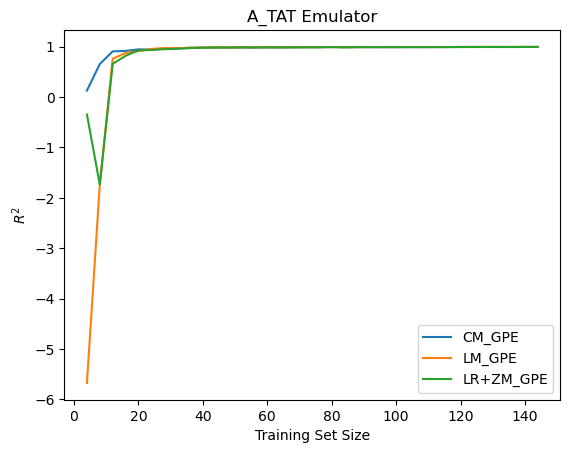

In [147]:
plt.plot(output[:,0],1-output[:,1]/np.var(y_train.iloc[:,0]))
plt.plot(output[:,0],1-output[:,3]/np.var(y_train.iloc[:,0]))
plt.plot(output[:,0],1-output[:,5]/np.var(y_train.iloc[:,0]))
plt.legend(['CM_GPE','LM_GPE','LR+ZM_GPE'])
plt.ylabel('$R^2$')
plt.xlabel('Training Set Size')
#plt.ylim([0,2])
plt.title('A_TAT Emulator')
#plt.yscale('log')

In [138]:
y_train.iloc[:,1]

165    119.5720
179    115.3070
11     101.4400
170    148.1340
27     124.4890
         ...   
103    112.1920
151    185.3150
67     119.3370
25      88.5843
175     94.4139
Name: (V_TAT,), Length: 144, dtype: float64

In [140]:
output[:,2]/np.var(y_train.iloc[:,1])

array([2.17018608, 0.40456902, 0.22881317, 0.13836023, 0.10039859,
       0.08257954, 0.08552501, 0.06007196, 0.04837718, 0.03229789,
       0.02726186, 0.02662128, 0.02666879, 0.01961736, 0.01488796,
       0.02074842, 0.01363158, 0.014745  , 0.01153232, 0.01100389,
       0.01115241, 0.00859116, 0.00935858, 0.00766955, 0.00815077,
       0.00589304, 0.00635474, 0.00559502, 0.00584066, 0.00574144,
       0.00584671, 0.00569112, 0.00549351, 0.0054313 , 0.00502557,
       0.0051403 ])

Text(0.5, 1.0, 'V_TAT Emulator')

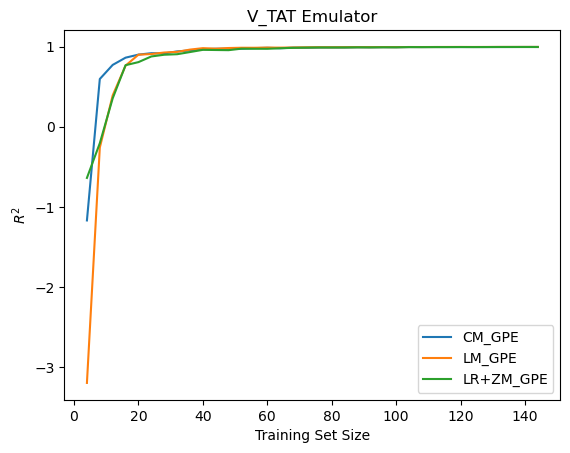

In [148]:
plt.plot(output[:,0],1-output[:,2]/np.var(y_train.iloc[:,1]))
plt.plot(output[:,0],1-output[:,4]/np.var(y_train.iloc[:,1]))
plt.plot(output[:,0],1-output[:,6]/np.var(y_train.iloc[:,1]))
plt.legend(['CM_GPE','LM_GPE','LR+ZM_GPE'])
plt.ylabel('$R^2$')
plt.xlabel('Training Set Size')
plt.title('V_TAT Emulator')
#plt.yscale('log')

In [143]:
y_train.iloc[0]

(A_TAT,)    315.529
(V_TAT,)    119.572
Name: 165, dtype: float64

In [92]:
modelsLR[0].mean_module.bias

Parameter containing:
tensor([1.2087], requires_grad=True)

In [93]:
regression_model.intercept_

array([-3.85106790e-16, -2.59881014e-17])

In [94]:
regression_model.coef_

array([[-0.04102392, -0.0317228 ,  0.02013112, -0.96778083, -0.13287232,
        -0.11695252],
       [-0.78719965, -0.24660796, -0.51463569,  0.03664458,  0.02593597,
         0.03586353]])

In [95]:
modelsLR[0].mean_module.weights

Parameter containing:
tensor([[-0.0078],
        [ 0.0030],
        [ 0.0046],
        [-1.3449],
        [-0.1956],
        [-0.4554]], requires_grad=True)

In [96]:
output[35,:]

array([144.        ,  23.64440761,   6.78404263,  19.27449415,
         5.92477178,  22.87568176,   7.04792228])

In [97]:
models, likelihoods = GPEnsemble(inputNorm,outputNorm)

0
1


In [98]:
modelsLR, likelihoodsLR = GPEnsemble(inputNorm,outputNorm,meanFunc="linear")

0
1


In [99]:
regression_model, modelsZM, likelihoodsZM=LRGPEnsemble(inputNorm,outputNorm)

0
1


In [100]:
((GPEnsemblePredict(modelsLR,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[1]-torch.tensor(y_test.values)[:,1])**2).mean()

TypeError: GPEnsemblePredict() missing 1 required positional argument: 'outStd'

In [ ]:
np.min(y)

In [ ]:
MSE = np.zeros((3,2))
for i in range(2):
    MSE[0,i] =((GPEnsemblePredict(models,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
    MSE[1,i] =((GPEnsemblePredict(modelsLR,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
    MSE[2,i] =((LRGPEnsemblePredict(regression_model,modelsZM,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[i]-torch.tensor(y_test.values)[:,i])**2).mean()
   
    

In [ ]:
MSE

In [ ]:
x_coord=np.linspace(1,len(X_test),len(X_test))

In [ ]:
x_coord

In [ ]:
plt.plot(x_coord,((GPEnsemblePredict(models,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[0])).tolist(),'o')
plt.plot(x_coord,y_test.values[:,0],'o')

In [ ]:
plt.plot(x_coord,((GPEnsemblePredict(modelsLR,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)[1])).tolist(),'o')
plt.plot(x_coord,y_test.values[:,1],'o')

In [ ]:
MSE

In [ ]:
torch.split(torch.tensor(y_test.values.T),1,dim=0)

In [ ]:
GPEnsemblePredict(modelsLR,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)

In [ ]:
LRGPEnsemblePredict(regression_model, modelsZM,torch.tensor(((X_test-inputMean)/inputStd).values),outMean,outStd)

In [ ]:
nMod=outputNorm.shape[1]
nInput = inputNorm.shape[1]

In [ ]:
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(inputNorm.iloc[:,i]),np.max(inputNorm.iloc[:,i])])
    print(boundsMaxMin[i])

In [ ]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nInput,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 4096)

data1 = torch.tensor(param_values)
Ymean=GPEnsemblePredict(models,data1,outMean,outStd)
YmeanLR = GPEnsemblePredict(modelsLR,data1,outMean,outStd)
# Run model (example)
#outMean = np.mean(modelOutputOrig,axis=0)
#outStd = np.std(modelOutputOrig,axis=0)
#nMod = modelOutputOrig.shape[1]
#Ymean=[]
#for j in range(nMod):
#    models[j].eval()
#    #Ymean.append(np.zeros([param_values.shape[0]]))
#    Ymean.append(outStd[j]*models[j](torch.tensor([np.hstack((param_values,np.zeros((param_values.shape[0],9))))])).mean+outMean[j])

    

In [ ]:
data1.size()

In [ ]:
Si = []
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[i].detach().numpy(), print_to_console=True))

In [ ]:
SiLR = []
for i in range(nMod):
    SiLR.append(sobol.analyze(problem, YmeanLR[i].detach().numpy(), print_to_console=True))

# Model 2: Linear regression + Zero Mean GP

In [91]:


# generate random data-set

# sckit-learn implementation

# Model initialization
#regression_model = LinearRegression()
# Fit the data(train the model)
#regression_model.fit(modeWeights, modelOutput)
# Predict
#y_predicted = regression_model.predict(modeWeights)

# model evaluation
#rmse = mean_squared_error(modelOutput, y_predicted)
#r2 = r2_score(modelOutput, y_predicted)

# printing values
#print('Slope:' ,regression_model.coef_)
#print('Intercept:', regression_model.intercept_)
#print('Root mean squared error: ', rmse)
#print('R2 score: ', r2)


In [92]:
#modelOutputAdjusted = modelOutput - y_predicted

In [93]:
#modelsZM, likelihoodsZM = GPEnsemble(modeWeights,modelOutputAdjusted,zeroMean=True)

In [94]:
YmeanSens = LRGPEnsemblePredict(regression_model,modelsZM,data1,outMean,outStd)

In [95]:
SiZM = []
for i in range(nMod):
    SiZM.append(sobol.analyze(problem, YmeanSens[i].detach().numpy().squeeze(), print_to_console=True))

                        ST   ST_conf
(CV_ventricles,)  0.000124  0.000012
(k_ventricles,)   0.000154  0.000015
(k_FEC,)          0.000164  0.000015
(CV_atria,)       0.936566  0.032402
(k_atria,)        0.022685  0.001282
(k_BB,)           0.048647  0.003067
                        S1   S1_conf
(CV_ventricles,) -0.000087  0.000482
(k_ventricles,)   0.000022  0.000536
(k_FEC,)          0.000007  0.000632
(CV_atria,)       0.927657  0.037487
(k_atria,)        0.020641  0.006433
(k_BB,)           0.042627  0.009614
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                        ST   ST_conf
(CV_ventricles,)  0.986275  0.028804
(k_ventricles,)   0.005825  0.000510
(k_FEC,)          0.013069  0.001110
(CV_atria,)       0.000946  0.000098
(k_atria,)        0.001729  0.000247
(k_BB,)           0.000267  0.000030
                        S1   S1_conf
(CV_ventricles,)  0.979211  0.058461
(k_ventricles,)   0.004557  0.003321
(k_FEC,)          0.010594  0.005128
(CV_atria,)       0.000298

In [96]:
SiZM_first=np.zeros((nInput,nMod))
SiZM_total=np.zeros((nInput,nMod))
Si_first=np.zeros((nInput,nMod))
Si_total=np.zeros((nInput,nMod))
SiLR_first=np.zeros((nInput,nMod))
SiLR_total=np.zeros((nInput,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = SiZM[i].to_df()
    SiZM_first[:,i] =  first_Si.iloc[:,0]
    SiZM_total[:,i] =  total_Si.iloc[:,0]
    
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]
    
    total_Si, first_Si, second_Si = SiLR[i].to_df()
    SiLR_first[:,i] =  first_Si.iloc[:,0]
    SiLR_total[:,i] =  total_Si.iloc[:,0]

## Linear Regression + GP

NameError: name 'SiZM_first' is not defined

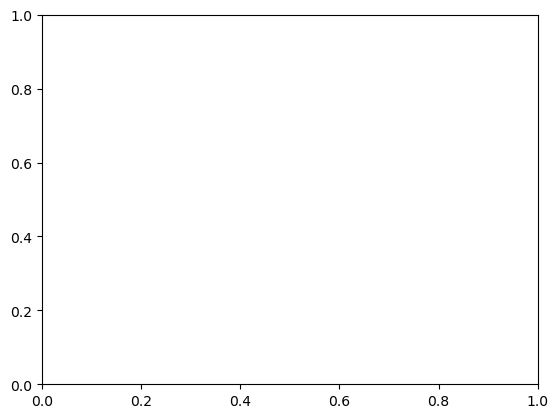

In [27]:
inputs = x_labels.values.tolist()
outputs = y_labels.values.tolist()
fig, ax = plt.subplots()
im = ax.imshow(SiZM_first)

ax.set_xticks(np.arange(len(outputs)), labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [ ]:
SiZM_first[:,0]

ValueError: Wedge sizes 'x' must be non negative values

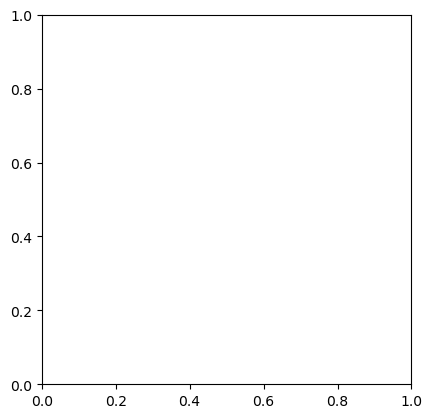

In [100]:
fig, ax = plt.subplots()
ax.pie(SiZM_first[:,0]/np.max(SiZM_first[:,0]), labels=inputs);


In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(SiZM_total/np.max(SiZM_total))

ax.set_xticks(np.arange(len(outputs)), labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");
plt.colorbar(im,fraction=0.015, pad=0.04)

## Basic GP

In [101]:
np.max(SiZM_total)

0.9862749320237507

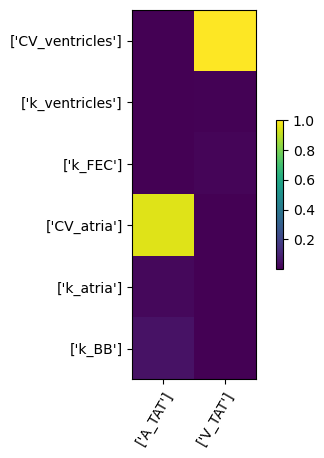

In [102]:
fig, ax = plt.subplots()
im = ax.imshow(Si_total/np.max(Si_total))

ax.set_xticks(np.arange(len(outputs)), labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [103]:
Si_first[:,0]

array([-1.61388330e-04,  4.27473995e-05,  3.33915828e-04,  9.30185871e-01,
        2.00185743e-02,  4.06494230e-02])

In [ ]:
fig, ax = plt.subplots()
ax.pie(Si_first[:,0]/np.max(Si_first[:,0]), labels=inputs);


In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(Si_first/np.max(Si_first))

ax.set_xticks(np.arange(len(outputs)), labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

# Linear Mean GP

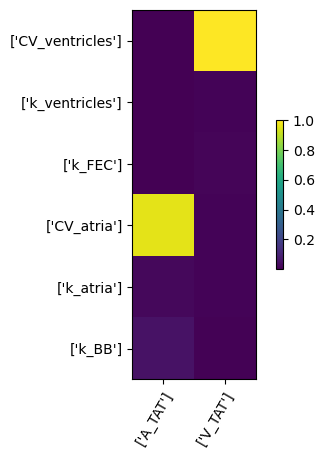

In [104]:
fig, ax = plt.subplots()
im = ax.imshow(SiLR_total/np.max(SiLR_total))

ax.set_xticks(np.arange(len(outputs)), labels=outputs)
ax.set_yticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

# Leave one out MSE

In [105]:
import random

In [106]:
def standardise(data,mean,std):
    dataStandard = (data-mean)/std.T
    return dataStandard

In [107]:
def EnsembleMSE(models,modelInput,modelOutput):
    MSE = np.zeros(modelOutput.shape[1])
    nMod=len(models)
    for i in range(nMod):
        models[i].eval()
        
        MSE[i] = (((outputTrainStd[i]*models[i](torch.tensor(modelInput.values).float()).mean-outputTrainStd[i]*torch.tensor(modelOutput.iloc[:,i].values))**2).mean());
    return MSE

In [108]:
def LREnsembleMSE(GPmodels,LRModel,modelInput,modelOutput):
    MSE = np.zeros(modelOutput.shape[1])
    nMod = len(models)
    y_predicted = regression_model.predict(modelInput)
    for i in range(nMod):
        GPmodels[i].eval()
        
        MSE[i] = (((outputTrainStd[i]*(torch.tensor(y_predicted[:,i])+GPmodels[i](torch.tensor(modelInput.values).float()).mean)-outputTrainStd[i]*torch.tensor(modelOutput.iloc[:,i].values))**2).mean());
    return MSE

In [109]:
random.sample(range(0,50),10)

[14, 23, 24, 8, 12, 2, 5, 46, 15, 32]

In [110]:
GP_MSE = np.zeros(outputNorm.shape[1])
LRGP_MSE = np.zeros(outputNorm.shape[1])
LMGP_MSE = np.zeros(outputNorm.shape[1])
iters = inputNorm.shape[0]
nMod = outputNorm.shape[1]

for i in range(iters):

    models2=[]
    modelsLR2 = []
    modelsZM2=[]


    testIndices = [i]
    inputTest = inputOrig.iloc[testIndices,:]
    inputTrain = inputOrig[~inputOrig.index.isin([inputOrig.index[i]])]
    outputTest = outputOrig.iloc[testIndices,:]
    outputTrain = outputOrig.iloc[~outputOrig.index.isin([outputOrig.index[i]])]
    
    inputTrainNorm,inputTrainMean,inputTrainStd = normalise(inputTrain)
    inputTestNorm=(inputTest-inputTrainMean)/inputTrainStd
    
    outputTrainNorm,outputTrainMean,outputTrainStd = normalise(outputTrain)
    outputTestNorm=(outputTest-outputTrainMean)/outputTrainStd
    
    y_predicted = regression_model.predict(inputTrainNorm)

    for j in range(nMod):

        likelihood2 = gpytorch.likelihoods.GaussianLikelihood()
        model2 = ExactGPModel(torch.tensor(inputTrainNorm.values), torch.tensor(outputTrainNorm.iloc[:,j].values).squeeze(), likelihood2)


        model2.likelihood.noise_covar.noise= models[j].likelihood.noise_covar.noise,
        model2.covar_module.base_kernel.lengthscale= models[j].covar_module.base_kernel.lengthscale.tolist(),
        model2.covar_module.outputscale=models[j].covar_module.outputscale,
        model2.mean_module.constant=models[j].mean_module.constant.tolist()
        model2.train()
        models2.append(model2)
        
        likelihoodLR2 = gpytorch.likelihoods.GaussianLikelihood()
        modelLR2 = ExactLRGPModel(torch.tensor(inputTrainNorm.values).float(), torch.tensor(outputTrainNorm.iloc[:,j].values).squeeze().float(), likelihoodLR2)


        modelLR2.likelihood.noise_covar.noise= modelsLR[j].likelihood.noise_covar.noise,
        modelLR2.covar_module.base_kernel.lengthscale= modelsLR[j].covar_module.base_kernel.lengthscale.tolist(),
        modelLR2.covar_module.outputscale=modelsLR[j].covar_module.outputscale,
        modelLR2.mean_module.weights=modelsLR[j].mean_module.weights
        modelLR2.mean_module.bias=modelsLR[j].mean_module.bias
        modelLR2.train()
        modelsLR2.append(modelLR2)
        
    
        modelOutputAdjusted = outputTrainNorm - y_predicted
        
        likelihoodZM2 = gpytorch.likelihoods.GaussianLikelihood()
        modelZM2 = ZeroMeanGPModel(torch.tensor(inputTrainNorm.values), torch.tensor(modelOutputAdjusted.iloc[:,j].values).squeeze(), likelihood2)

        modelZM2.likelihood.noise_covar.noise= modelsZM[j].likelihood.noise_covar.noise,
        modelZM2.covar_module.base_kernel.lengthscale= modelsZM[j].covar_module.base_kernel.lengthscale.tolist(),
        modelZM2.covar_module.outputscale=modelsZM[j].covar_module.outputscale,
        #modelZM2.mean_module.constant=modelsZM[j].mean_module.constant.tolist()
        modelZM2.train()
        modelsZM2.append(modelZM2)
        
    GP_MSE+= EnsembleMSE(models2,inputTestNorm,outputTestNorm)/iters
    LRGP_MSE+=LREnsembleMSE(modelsZM2,regression_model,inputTestNorm,outputTestNorm)/iters
    LMGP_MSE+=EnsembleMSE(modelsLR2,inputTestNorm,outputTestNorm)/iters

In [111]:
dataset = pd.DataFrame({'GP MSE': GP_MSE, 'LRGP MSE': LRGP_MSE,'LMGP MSE': LMGP_MSE}, columns=['GP MSE', 'LRGP MSE', 'LMGP MSE'])
dataset.index = list(outputOrig.columns)

In [112]:
dataset

,GP MSE,LRGP MSE,LMGP MSE
"(A_TAT,)",7.589008,5.806195,6.934430
"(V_TAT,)",9.207133,7.648779,78.581577


In [113]:
LRGP_MSE.tolist()

[5.806195411983605, 7.648779139608493]

In [114]:
GP_MSE = np.zeros(outputNorm.shape[1])
LRGP_MSE = np.zeros(outputNorm.shape[1])

for i in range(iters):

    testIndices = [i]
    inputTest = inputOrig.iloc[testIndices,:]
    inputTrain = inputOrig[~inputOrig.index.isin([inputOrig.index[i]])]
    outputTest = outputOrig.iloc[testIndices,:]
    outputTrain = outputOrig.iloc[~outputOrig.index.isin([outputOrig.index[i]])]
    
    inputTrainNorm,inputTrainMean,inputTrainStd = normalise(inputTrain)
    inputTestNorm=(inputTest-inputTrainMean)/inputTrainStd
    
    outputTrainNorm,outputTrainMean,outputTrainStd = normalise(outputTrain)
    outputTestNorm=(outputTest-outputTrainMean)/outputTrainStd
    
    models, likelihoods= GPEnsemble(inputTrainNorm,outputTrainNorm)
    
    GP_MSE+= EnsembleMSE(models,inputTestNorm,outputTestNorm)/iters
    
    regression_model, modelsZM, likelihoodsZM = LRGPEnsemble(inputTrainNorm,outputTrainNorm)
    
    
    LRGP_MSE+=LREnsembleMSE(modelsZM,regression_model,inputTestNorm,outputTestNorm)/iters

0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1
0
1


In [115]:
GP_MSE

array([6.82964604, 8.93171717])

In [116]:
dataset = pd.DataFrame({'GP MSE': GP_MSE, 'LRGP MSE': LRGP_MSE}, columns=['GP MSE', 'LRGP MSE'])
dataset.index = list(outputOrig.columns)

In [117]:
dataset

,GP MSE,LRGP MSE
"(A_TAT,)",6.829646,5.264156
"(V_TAT,)",8.931717,7.267701


In [118]:
modelInput=inputTestNorm
y_predicted = regression_model.predict(modelInput)
outputTrainStd[i]*(torch.tensor(y_predicted[:,i])+modelsZM[i](torch.tensor([modelInput.values])).mean)

IndexError: index 114 is out of bounds for axis 0 with size 2

In [ ]:
i=0

In [ ]:
((outputTrainStd[i]*(torch.tensor(y_predicted[:,i])+modelsZM[i](torch.tensor([modelInput.values])).mean)-outputTrainStd[i]*torch.tensor(outputTestNorm.iloc[:,i].values))).mean()

In [ ]:
outputTrainStd[i]*(torch.tensor(y_predicted[:,i])+modelsZM[i](torch.tensor([modelInput.values])).mean)

In [ ]:
outputTrainStd[i]*(torch.tensor(outputTestNorm.iloc[:,i].values))

In [ ]:
-33.5787+35.2118

In [ ]:
(0.08440000000000003)**2

In [ ]:
torch.tensor(y_predicted[:,i])+modelsZM[i](torch.tensor([modelInput.values])).mean-torch.tensor(outputTestNorm.iloc[:,i].values)